# Exercise Sheet 4: Neural Mass Models & Networks

In [62]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import spatial
from scipy import signal
import itertools
import math

def logistic(h,a=1):
    return 1/(1+np.exp(-a*h))
def dlogistic(h,a=1):
    return a*(logistic(h,a)-np.power(logistic(h,a),2))

def gaussRBF(h,a=1):
    return np.exp(-(a*h)**2)

def dgaussRBF(h,a=1):
    return -2*a**2*h*np.exp(-(a*h)**2)

## Code given: Gradient Descent on a single neuron and an MLP
The neuron class below from sheet 1 is extended and includes the Gradient Descent training algorithm as a method. It uses the sum of squares error to measure the output error.
A method calculating the last local error ($\delta$) of the neuron and one for training the neuron using the derivative of the ouput error $\frac{dE}{dy}=y-o$ is included.

The train function updates the weights by the gradient descent weight update rule $w(t+1)=w(t)-\eta\delta(t)\cdot x(t)$ and the bias by $b(t+1)=b(t)-\eta\delta(t)$ with $\eta$ being the learning rate. As input arguments it should get the derivative of the output error $\frac{dE}{dy}=y-o$ and the learning rate.

The class "MLP" includes a list of layers of type "MLPlayer" called "MLP.layers" Also, there is a method "MLP.out(x)" that returns the outputs of the whole network of the input vector "x".

The size of the weight vector is set to the number of inputs for the first layer and the number of inputs for the following layers corresponds to the number of neurons in the preceding layer. The number of outputs equals the number of neurons in the last layer.

The backpropagation training algorithm is included as a method "MLP.train()" into the class. The passed arguments should consist of the number of iterations (no stopping criteria in this case), the training input and the training output - both as function pointers - as well as the learning rate. It iterates over the layers, which themselves iterate over their neurons. Deltas and W of the following layer will allways be the input to the previous.

The function pointer argument x_train has to link to a function that produce a random array of inputs of size [NoInputs,] and o_train has to produce the corresponding target function output for a given input. x_train should work without an argument passed and the target training output $o$ should be calculated using only that vector $x$.

The output of the method *train()* consists of the sum-of-squares error within each iteration.

In [37]:
class neuron:    
    lasth=0
    lastout=0
    lastin=0
    
    def __init__(self,w,b,trafunc=logistic,dtrafunc=dlogistic):
        self.w=np.array(w)
        self.b=np.array(b)
        self.trafunc=trafunc
        self.dtrafunc=dtrafunc
        
    def out(self, x):
        self.lastin=x;
        self.lasth=np.dot(self.w,x)-self.b
        self.lastout=self.trafunc(self.lasth)
        return self.lastout   
    
    def delta(self,deltanext,weightsnext):
        df=self.dtrafunc(self.lasth)
        self.lastdelta=np.dot(deltanext,weightsnext)*df     
        return self.lastdelta
    
    def train(self,deltanext,weightsnext,learnrate=0.1):
        self.delta(deltanext,weightsnext)
        self.w=self.w-learnrate*self.lastdelta*self.lastin
        self.b=self.b+learnrate*self.lastdelta
        return self.lastdelta

class MLPlayer:
    def __init__(self,NodeNo,WeightNo,weightinit=np.random.randn,biasinit=np.random.randn,trafunc=logistic,dtrafunc=dlogistic):
        self.nodes=[neuron(weightinit(WeightNo),biasinit(1),trafunc,dtrafunc) for i in range(NodeNo)]
    def out(self,x):
        return np.ravel([n.out(x) for n in self.nodes])
    def train(self,deltanext,W,learnrate=0.1):    
        Wo=np.array([n.w for n in self.nodes]).T
        deltas=np.array([ n.train(deltanext,W[ineur],learnrate) for ineur,n in enumerate(self.nodes)]).T
        return deltas, Wo

class MLP:
    def __init__(self,InputNo,NodeNos,weightinit=np.random.randn,biasinit=np.random.randn,trafunc=logistic,dtrafunc=dlogistic):        
        self.NodeNos=np.append(InputNo,NodeNos)
        self.layers=[MLPlayer(self.NodeNos[i+1],self.NodeNos[i],weightinit,biasinit,trafunc,dtrafunc) for i in range(self.NodeNos.size-1)]
    def out(self,x):
        for i in range(len(self.layers)):
            x=self.layers[i].out(x)
        self.lastout=x
        return x
    def train(self,NumIt,x_train,o_train,learnrate=0.1):
        errors=np.zeros(NumIt)
        for i in range(NumIt):
            if callable(x_train):
                x=x_train()
            else:
                x=x_train[i]
            if callable(o_train):
                o=o_train(x)
            else:   
                o=o_train[i]                       
            y=self.out(x)
            if len(y)==1:
                o=np.array([o]) 
                y=np.array([y])
            deltas=y-o
            W=np.eye(y.shape[0])   
            for il, l in enumerate(reversed(self.layers)): 
                deltas, W=l.train(deltas,W,learnrate)
            errors[i]=0.5*np.sum(np.power(y-o,2))       
        return errors

## Task 1: logical functions (2 points - programming)
Train a single neuron on the logical functions below for a two-dimensional input $x$. Use instances of the neuron class above to build the equivalents to logical "or","and" and "xor"-functions and test them for 2-dimensional input vectors *x* resembling all possibilities of combinations ([0,0] [1,0], [0,1], [1,1]). Do 10.000 iterations and plot the evolution of the error (the error over the iteration number). You don't need to implement a stopping criterion.

Set the learning rate to $\eta=1$ and initialize the weight $w$ and the bias $b$ randomly with normal distribution (np.random.randn). Use the logistic function.

In the next cell you find an exemplary random number generator and the corresponding functions you can use for sample creation in every single iteration. In every iteration use the random input $x$, the neuron output *$y=$neuron.out($x$)* and the training data $o=targefunction(x)$

In [38]:
def train_and_display(NumIt,neuron1,inputfunc,targetfunc):
    errors=np.zeros(NumIt)
    for i in range(NumIt):
        x=inputfunc()
        neuron1.train(neuron1.out(x)-targetfunc(x),1)
        errors[i]=0.5*np.sum(np.power(neuron1.out(x)-targetfunc(x),2))
    plt.plot(errors)
    return neuron1

In [39]:
w = np.random.randn(2)
b = np.random.randn(1)

neuron1 = neuron(w, b)

In [40]:
logical_comb = lambda: np.random.randint(2, size=(2, ))
or_function = lambda x: x[0] or x[1]
xor_function = lambda x: x[0] ^ x[1]

Predicted -> 1 OR 0 = 0.8230299649303422
Expected  -> 1 OR 0 = 1


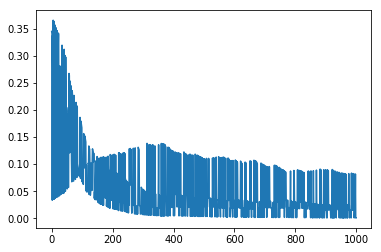

In [41]:
train_and_display(1000,neuron1, logical_comb, or_function)
x = logical_comb()
print(f"Predicted -> {x[0]} OR {x[1]} = {neuron1.out(x)[0]}")
print(f"Expected  -> {x[0]} OR {x[1]} = {or_function(x)}")

Predicted -> 0 XOR 0 = 0.3051262517692612
Expected  -> 0 XOR 0 = 0


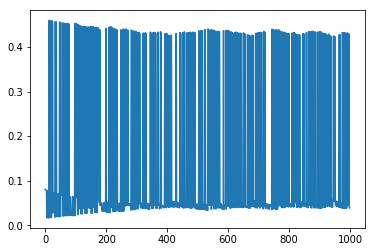

In [42]:
train_and_display(1000,neuron1, logical_comb, xor_function)
x = logical_comb()
print(f"Predicted -> {x[0]} XOR {x[1]} = {neuron1.out(x)[0]}")
print(f"Expected  -> {x[0]} XOR {x[1]} = {xor_function(x)}")

## Task 2 Train an MLP on the XOR (2 points - programming)
Train a Multi-Layer-Perceptron on the logical "xor"-function. Do the same training on an XOR as in exercise 1, using an architecture of 2 and then 3 neurons in the first layer and one output neuron in the second (you may use the sample solution code). Do 10.000 iterations and plot the evolution of the error. You don't need to implement a stopping criterion. Use the logistic transfer function.

Set the learning rate to $\eta=1$.

Investigate the following steps:

a) The network should consist of two layers, where the first has the two input neurons and the second only one output neuron. Does it always converge?

b) The network should consist of two layers, where the first has the three  input neurons and the second only one output neuron. Does it now always converge?

What can we learn from this?

The MLP is already implemented above.
The syntax of the contained MLP class is:
*NeuralNetwork=MLP(NoInputs,ListNoNeuronsPerLayer)*
for initialization and 
*errors=NeuralNetwork.train(NoIterations,x, o ,learnrate)* for training. $x$ and $o$ can either be function pointers as defined or arrays of samples. If they are functions, $x$ has to produce a random array of inputs of size [NoInputs,] and $o(x)$ has to produce the corresponding target function output. If they are samples they have to have the shape *x.shape=[NoIterations,NoInputs]* and *o.shape=[NoIterations,NoOutputs]*.

See descriptions above for further explanations.



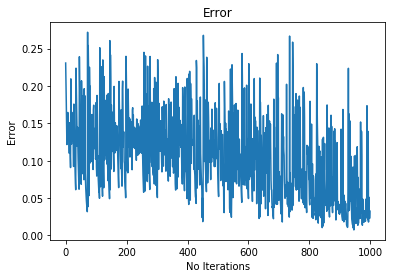

Predicted -> 0 XOR 0 = 0.22311100094263558
Expected  -> 0 XOR 0 = 0


In [43]:
neuralnet=MLP(2,[2,1])
errors = neuralnet.train(1000,logical_comb,xor_function ,1)
plt.figure()
plt.title("Error")
plt.xlabel("No Iterations")
plt.ylabel("Error")
plt.plot(errors)
plt.show()

x = logical_comb()
print(f"Predicted -> {x[0]} XOR {x[1]} = {neuralnet.out(x)[0]}")
print(f"Expected  -> {x[0]} XOR {x[1]} = {xor_function(x)}")

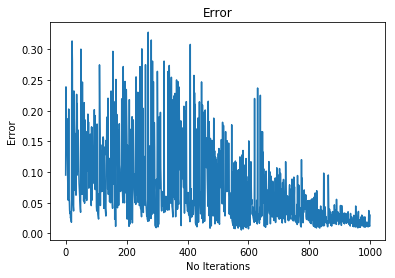

Predicted -> 1 XOR 0 = 0.8086941843133856
Expected  -> 1 XOR 0 = 1


In [44]:
neuralnet=MLP(2,[3, 1])
errors = neuralnet.train(1000,logical_comb,xor_function ,1)
plt.figure()
plt.title("Error")
plt.xlabel("No Iterations")
plt.ylabel("Error")
plt.plot(errors)
plt.show()

x = logical_comb()
print(f"Predicted -> {x[0]} XOR {x[1]} = {neuralnet.out(x)[0]}")
print(f"Expected  -> {x[0]} XOR {x[1]} = {xor_function(x)}")

As can be seen in the below graphs, the larger the number of layer is, better the performance of the training is. That's why, it is witnessed that in the first experiment, the model has not enough layers to make the model converge. However, On the second one, we visualize that the performance of the model improves a lot althought using a more layers with more nodes per layer the performance will reduce the error (in 1000 iterations) to nearly 0. 

## Task 3: A neural network described by a connectivity matrix (5 points - programming)
We will now translate the network described by objects into a connectivity matrix and then iterate over points in time in order to propagate the input to the output.

The connectivity is only supposed to be close to instantaneous in this task, we will introduce delay between different areas in the next task. The connectivity is hence a matrix $W$ of size (NoNeurons, NoNeurons).

The vector of network state variables $\mathbf{x}_t$  at time point $t$ shall include the input in the first variables. The new state $\mathbf{x}_{t+1}$ for the next time step is calculated by:
$\mathbf{x}_{t+1}=f(\mathbf{h})=f(\mathbf{W} \cdot \mathbf{x}_{t} -\mathbf{b})$

**Tasks:**

a) Calculate the connectivity matrix $W$ and the bias vector $\mathbf{b}$ out of the MLP from task 2 b) (if you have not succeeded with training the MLP simply use a feedforward MLP of size (3,1) with arbitrary wiring). To this extent, translate layerwise indexed neurons into a unique index across layers and then connect neurons from each layer only with the preceeding layer/the input, respectively. Print the matrix to command line.

b) Simulate a propagation of a random logic vector of size 2 (as in task 2) until it reaches the output layer. This means iteration over time points, where in each time point the output $f(\mathbf{h})$ from the preceeding time point $t$  is used as the input for the next time point $t+1$. Print the state variables $x_t$ at every step and the output of the network at the end to the command line.

In [45]:
NodesNos = [3, 1]

NumLayer = 2

W = []
B = []

for lay in range(NumLayer):
    
    Wi = []
    Bi = []
    for node in range(NodesNos[lay]):
        Wi.append(neuralnet.layers[lay].nodes[node].w)
        Bi.append(neuralnet.layers[lay].nodes[node].b)
    Wi = np.array(Wi)
    Bi = np.array(Bi)
    print(f"W layer {lay+1}:\n{Wi}")
    print(f"bias layer {lay+1}:\n{Bi}")

    W.append(Wi)
    B.append(Bi)
    
    

W layer 1:
[[-4.8181764  -4.63297141]
 [ 2.63117232  2.81491479]
 [ 1.57295772 -0.01894872]]
bias layer 1:
[[-1.27417708]
 [ 4.22642875]
 [ 0.46191361]]
W layer 2:
[[-5.7396476  -4.8810921  -0.97001079]]
bias layer 2:
[[-3.1556878]]


In [46]:
x = np.array([1, 1])
num_layer = len(W)
print(f"input = {x}")

inp = x
for i in range(num_layer):
    out = logistic(W[i]@inp.T - B[i].T)
    inp = out
    if(i<num_layer-1):
        print(f"Layer {i+1} output ={out}")
        
print(f"Final output ={out}")
    
print(f"Final output (task2)= {neuralnet.out(x)}")

input = [1 1]
Layer 1 output =[[2.80973068e-04 7.72003422e-01 7.48776093e-01]]
Final output =[[0.20743351]]
Final output (task2)= [0.20743351]


In [47]:
Size = 6
W = np.zeros((Size, Size))

W[2, 0:2] = neuralnet.layers[0].nodes[0].w
W[3, 0:2] = neuralnet.layers[0].nodes[1].w
W[4, 0:2] = neuralnet.layers[0].nodes[2].w
W[5, 2:5] = neuralnet.layers[1].nodes[0].w
print(f"W = \n{W}")



W = 
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [-4.8181764  -4.63297141  0.          0.          0.          0.        ]
 [ 2.63117232  2.81491479  0.          0.          0.          0.        ]
 [ 1.57295772 -0.01894872  0.          0.          0.          0.        ]
 [ 0.          0.         -5.7396476  -4.8810921  -0.97001079  0.        ]]


In [48]:
X = np.zeros((6,))
X[0:2]= np.array([1, 1]) #input

B = []
NumLayer =2
NumNodes = [3, 1]
index = 2
for lay in range(NumLayer):
    Bi = np.zeros((6,))
    for node in range(NumNodes[lay]):
        Bi[index] = neuralnet.layers[lay].nodes[node].b
        index += 1
    B.append(Bi)
B = np.array(B)
for i, b in enumerate(B):
    print(f"bias {i+1} = {b}")

bias 1 = [ 0.          0.         -1.27417708  4.22642875  0.46191361  0.        ]
bias 2 = [ 0.         0.         0.         0.         0.        -3.1556878]


In [49]:
for i in range(NumLayer):
    
    X = logistic(W@X.T - B[i, :].T)
    print(f"X layer {i+1} {X}")
    
    
print("\n")
print(f"Y  = {X[5]}")
print(f"Y (exercise 2) = {neuralnet.out([1, 1])}")

X layer 1 [5.00000000e-01 5.00000000e-01 2.80973068e-04 7.72003422e-01
 7.48776093e-01 5.00000000e-01]
X layer 2 [0.5        0.5        0.00878772 0.93837278 0.68503416 0.20743351]


Y  = 0.20743350534979066
Y (exercise 2) = [0.20743351]


## Task 4 : Neural Mass Model (6 points - programming)

We will now look at a neural mass model based on the source positions from our head model (gridpos.npy).
You will find the connected equations again on the last slides of the current lecture.


** Tasks: **

a) Derive the distance matrix $\mathbf{D}$ from the source positions in gridpos using scipy.spatial.distance_matrix(...).

b) Calculate the matrix of weights $\mathbf{W}_0$ with dimensionality (NoSources,NoSources) by distance without delay using the equation $\mathbf{W}=a_0 e^{b_0\mathbf{D}}+a_1 e^{b_1\mathbf{D}}$. Use $a_0=0.03$, $b_0=10$ for replicating excitatory connections and $a_1=-0.25$ and $b_1=50$ for inhibitory. Plot the matrix $\mathbf{W}_0$ using imshow.

c) Calculate the delay $\Delta t=\frac{\mathbf{D}}{c}+\Delta t_0$ for each connection by using the transmission speed $c=0.5 \frac{m}{s}$ and the synaptic delay $\Delta t_0=2ms$ as a matrix corresponding to the dimensions of $\mathbf{D}$. Then introduce a sampling rate of $fs=100Hz$ and discretize the delay into time samples. Calculate the maximal time delay $T$.

d) Combine the results of b) and c) into an array of size (NoSources,NoSources,MaxDelay+1) by expanding $W_0$ into the time domain/delay. We will call this array $W$.

e) Simulate the multi-variate time course for a random starting point of the network over $1s$ with $fs=100Hz$ by creating a random array X of size (NoSources,MaxDelay+1) with uniform distribution (np.random.rand) and then propagate activity over time. To this extent, use the current state history array $\mathbf{X}$ of the network to calculate the source activity vector for the next time step by $\mathbf{y}=f(\mathbf{W} \odot \mathbf{X})$. $\odot$ can be calculated using np.tensordot(W,X,axes=2). Then $\mathbf{X}$ can be shifted like a circular buffer so that the oldest source activity vector is discarded while the newest is set to $\mathbf{y}$.

In [99]:
gridpos=np.load('gridpos.npy')
Nsource=gridpos.shape[0]

print(gridpos.shape)

(3990, 3)


In [100]:
D = spatial.distance_matrix(gridpos, gridpos)
print(D.shape)

(3990, 3990)


In [101]:
a0 = 0.03
b0 = 10
a1 = -0.25
b1 = 50 

W0 = a0*np.exp(-b0*D) + a1*np.exp(-b1*D)        

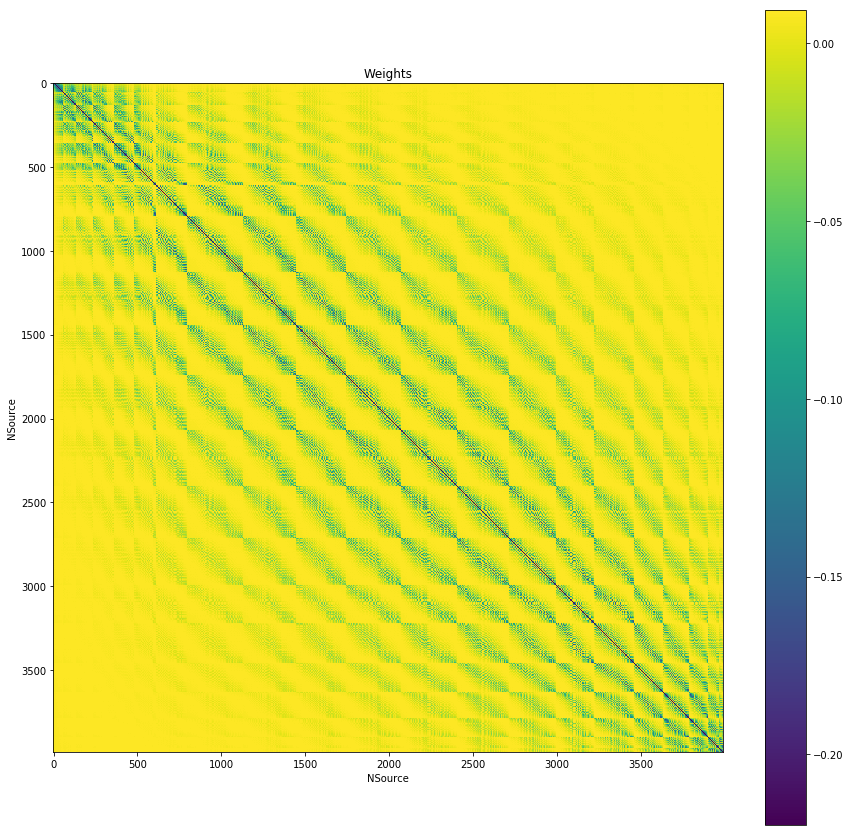

In [102]:
fig = plt.figure(figsize = (15, 15))
plt.title("Weights")
plt.xlabel("NSource")
plt.ylabel("NSource")
plt.imshow(W0)
plt.colorbar()
plt.show()

In [112]:
fs=1000
c=0.5
T0=2*10e-3

DeltaT = (D/c + T0)*fs

In [120]:
maxima_time_delay = np.max(DeltaT)
print(f"Maxima time delay = {maxima_time_delay} samples")

Maxima time delay = 363.4904433775779 samples


In [ ]:
W = n